In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Definir a rede neural para aproximar a função Q (a saída será um vetor contínuo de 3 valores)
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)  # 3 valores contínuos como saída
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # A saída será um vetor de 3 valores contínuos

# Definir a classe do agente de Q-learning com ação contínua
class QLearningAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        
        # Criar a rede neural Q e o otimizador
        self.q_network = QNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def select_action(self, state):
        # Política epsilon-greedy
        if random.random() < self.epsilon:
            # Selecionar uma ação aleatória dentro do espaço de ação contínuo
            return np.random.uniform(0, 1, self.action_dim)  # Ajuste de acordo com o seu espaço de ação
        else:
            # Selecionar a ação com maior valor de Q
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state_tensor).detach().numpy().flatten()
            return q_values  # Retorna a ação contínua

    def train(self, state, action, reward, next_state, done):
        # Converte os dados para tensores
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action_tensor = torch.FloatTensor(action).unsqueeze(0)
        reward_tensor = torch.FloatTensor([reward])
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

        # Calcula o valor Q da estado atual
        current_q_values = self.q_network(state_tensor)
        
        # Calcula o valor Q do próximo estado
        with torch.no_grad():
            next_q_values = self.q_network(next_state_tensor)
        
        # Calcula o alvo (Target Q)
        target_q_values = current_q_values.clone()
        target_q_values[0] = reward_tensor + (1 - done) * self.gamma * next_q_values.max(1)[0]

        # Calcula a perda (Loss)
        loss = self.criterion(current_q_values, target_q_values)

        # Atualiza os parâmetros do modelo
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Diminui o epsilon para a política epsilon-greedy
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

In [ ]:
class PortfolioEnv(gym.Env):
    def __init__(self):
        """
        Inicializa o ambiente.
        :param dados_preco: DataFrame ou numpy array com preços dos ativos.
                           Exemplo: colunas ['Gold', 'IBOVESPA', 'Bitcoin']
        :param dados_observacoes: DataFrame ou numpy array com observação do modelo 
                           Exemplo: IPCA.
        """
        dados = pd.read_csv('../data/merged_v1.csv')
        self.dados_preco = dados.iloc[:, 1:4]  # Dataframe com preços dos ativos
        self.dados_observacao = dados.iloc[:, 4]  # Dataframe com Observações (IPCA)
        self.current_step = 0  # Passo atual

        # Definindo espaço de ação: Proporções de alocação entre 0 e 1 (somatório das 3 proporções = 1)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

        # Definindo espaço de observação: IPCA (valor único)
        self.observation_space = spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32)

        # Estado inicial do portfólio
        self._estado_inicial_portfolio = 100  # Valor inicial do portfólio
        self._valor_portfolio = self._estado_inicial_portfolio
        self._episode_ended = False

    def reset(self):
        """Reinicia o ambiente para o próximo episódio"""
        if self.current_step >= len(self.dados_preco) - 1:
            # Se chegamos ao final dos dados, reinicie
            self.current_step = 0

        self._episode_ended = False
        self._valor_portfolio = self._estado_inicial_portfolio
        
        # Observação: IPCA no dia atual
        ipca = self.dados_observacao.iloc[self.current_step]
        return np.array([ipca], dtype=np.float32)

    def step(self, action):
        """Executa a ação no ambiente e retorna o novo estado, recompensa e se o episódio terminou"""
        if self._episode_ended:
            # Avança para o próximo dia e reinicia o ambiente se o episódio terminou
            self.current_step += 1
            return self.reset()

        # Normaliza as alocações (ação do agente)
        weights = np.array(action, dtype=np.float32)
        weights = weights / np.sum(weights)  # Garantir que a soma das alocações seja 1
        
        # Pega o preço atual e o preço do dia seguinte
        current_prices = self.dados_preco.iloc[self.current_step].values
        next_day_prices = self.dados_preco.iloc[self.current_step + 1].values

        # Calcula a variação percentual dos preços dos ativos
        variacao_precos_percentual = (next_day_prices - current_prices) / current_prices
        
        # Calcula o valor do portfólio no próximo dia
        valores_aportados = weights * self._estado_inicial_portfolio
        self._valor_portfolio = np.sum(valores_aportados * (1 + variacao_precos_percentual))

        # Condição de término: episódio acabou (avançamos para o próximo dia)
        self._episode_ended = True

        # Recompensa: lucro ou prejuízo
        reward = self._valor_portfolio - self._estado_inicial_portfolio
        
        # Observação: IPCA no dia atual
        ipca = self.dados_observacao.iloc[self.current_step]

        return np.array([ipca], dtype=np.float32), reward, self._episode_ended, {}

    def render(self):
        """Renderiza o estado atual"""
        print(f"Dia: {self.current_step}, Valor do portfólio: {self._valor_portfolio}")


C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Episode 1/1000, Total Reward: 3.1691890194755956, Epsilon: 0.99
Episode 2/1000, Total Reward: 3.2999006347632758, Epsilon: 0.99
Episode 3/1000, Total Reward: 3.9455574145438135, Epsilon: 0.99
Episode 4/1000, Total Reward: 4.651316777883721, Epsilon: 0.98
Episode 5/1000, Total Reward: 1.3600965163390129, Epsilon: 0.98
Episode 6/1000, Total Reward: 4.140495353733186, Epsilon: 0.97
Episode 7/1000, Total Reward: 2.128322568613072, Epsilon: 0.97
Episode 8/1000, Total Reward: 4.98362706464728, Epsilon: 0.96
Episode 9/1000, Total Reward: 4.712173295506176, Epsilon: 0.96
Episode 10/1000, Total Reward: 4.706356846186594, Epsilon: 0.95
Episode 11/1000, Total Reward: 3.0966448153394026, Epsilon: 0.95
Episode 12/1000, Total Reward: 1.8644015793165352, Epsilon: 0.94
Episode 13/1000, Total Reward: 1.550747992523867, Epsilon: 0.94
Episode 14/1000, Total Reward: 1.9107446609923642, Epsilon: 0.93
Episode 15/1000, Total Reward: 1.4103414147712954, Epsilon: 0.93
Episode 16/1000, Total Reward: 5.413140040

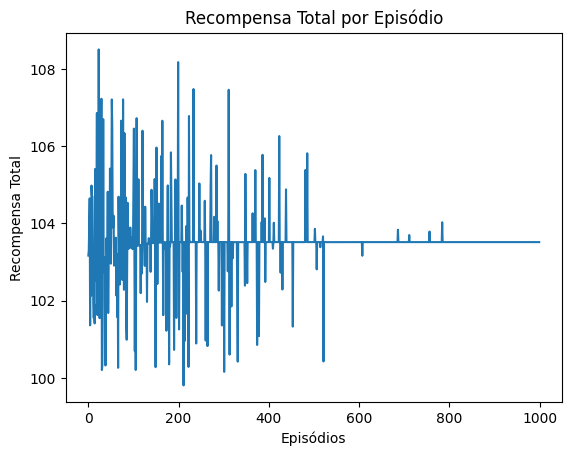

In [9]:
# Inicializar o ambiente e o agente
env = PortfolioEnv()
agent = QLearningAgent(1, 3)
portfolio_values = []
# Treinar o agente
total_episodes = 1000
for episode in range(total_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)  # Seleciona a ação
        next_state, reward, done, _ = env.step(action)  # Executa a ação no ambiente
        agent.train(state, action, reward, next_state, done)  # Treina o agente com a transição
        state = next_state  # Atualiza o estado
        total_reward += reward  # Soma a recompensa
    portfolio_values.append(env._valor_portfolio)
    print(f"Episode {episode+1}/{total_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")
plt.plot(portfolio_values)
plt.title('Recompensa Total por Episódio')
plt.xlabel('Episódios')
plt.ylabel('Recompensa Total')
plt.show()